In [15]:
from srcmap import *
from mask import *
from utils_plotting import *
from power_spec import *
from IPython.display import clear_output
import seaborn as sns
sns.set()

In [5]:
inst = 1
make_srcmap_class = make_srcmap(inst, Re2 = 2)

srcmap = make_srcmap_class.run_srcmap(ptsrc=True)
clear_output()

modmap = make_srcmap_class.run_srcmap()
clear_output()

mzmask, _ = MZ14_mask(inst, make_srcmap_class.xls, 
                   make_srcmap_class.yls, make_srcmap_class.ms_inband)
clear_output()

mzmask_mkk = mask_Mkk(mzmask)
mzmask_mkk.get_Mkk_sim(verbose=False)
clear_output()

psfmap = make_srcmap_class.psf_map

In [35]:
l,Cls0,Cls0err = get_power_spec(srcmap, mask=mzmask)
l,Clm0,Clm0err = get_power_spec(modmap, mask=mzmask)
Cls, Clserr = mzmask_mkk.Mkk_correction(Cls0, Clerr=Cls0err)
Clm, Clmerr = mzmask_mkk.Mkk_correction(Clm0, Clerr=Clm0err)
bl = get_bl(psfmap, l)

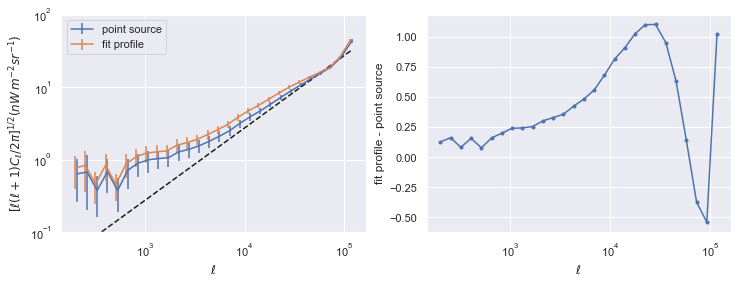

In [24]:
Dls = np.sqrt(Cls*l*(l+1)/2/np.pi/bl)
Dlm = np.sqrt(Clm*l*(l+1)/2/np.pi/bl)
Dlserr = np.sqrt(Clserr*l*(l+1)/2/np.pi/bl)
Dlmerr = np.sqrt(Clserr*l*(l+1)/2/np.pi/bl)
refline = np.sqrt(l*(l+1))
refline /= refline[-4]
refline *= np.sqrt(Cls*l*(l+1)/2/np.pi/bl)[-4]

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].errorbar(l*1.02, Dls, Dlserr, label='point source')
ax[0].errorbar(l*0.98, Dlm, Dlmerr, label='fit profile')
ax[0].plot(l, refline, 'k--')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_ylim([1e-1,1e2])
ax[0].set_xlabel(r'$\ell$')
ax[0].set_ylabel(r'$[ \ell(\ell+1)C_\ell/2\pi ]^{1/2}( nW\,m^{-2} sr^{-1})$')
ax[0].legend()

ax[1].semilogx(l, Dlm - Dls, '.-')
ax[1].set_xlabel(r'$\ell$')
ax[1].set_ylabel('fit profile - point source')
plt.savefig('plots/TM%d/excess_power_spec.png'%inst, dpi = 150, bbox_inches='tight')

***

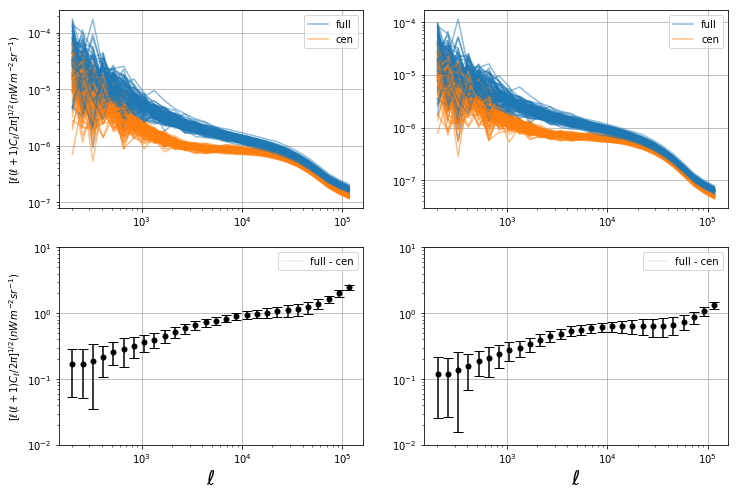

In [241]:
from PS_1h_test import *
# for ibatch in range(9):
#     run_1h_power_spec_test(ibatch)

fig, ax = plt.subplots(2,2, figsize=(12,8))

for i,inst in enumerate([1,2]):
    Dl_all = []
    for ibatch in range(9):
        fname = 'micecat_data/PS1h_test_ibatch%d.pkl'%(ibatch)
        with open(fname, "rb") as f:
            data = pickle.load(f)

        for j,icat in enumerate(list(data)):
            if isinstance(icat, str):
                continue
            Dlf = data[icat]['full'][inst]['Dl']
            Dlc = data[icat]['cen'][inst]['Dl']
            Clf = Dlf**2 * 2 * np.pi / l / (l+1)
            Clc = Dlc**2 * 2 * np.pi / l / (l+1)
            ax[0][i].loglog(l, Clf,'C0',label='full',alpha=0.5)
            ax[0][i].loglog(l, Clc,'C1',label='cen',alpha=0.5)
            ax[1][i].loglog(l, Clf-Clc,'C0',label='full - cen',alpha=0.1)
            
            Dl_all.append(Dlf-Dlc)
            if ibatch==0 and j==0:
                ax[0][i].legend()
                ax[1][i].legend()
                ax[0][i].grid()
                ax[1][i].grid()
                
    ax[1][i].errorbar(l,np.mean(np.array(Dl_all), axis=0), 
                      np.std(np.array(Dl_all), axis=0), fmt='.', capsize=5, markersize=10,c='k')
ax[1][0].set_xlabel(r'$\ell$',fontsize=20)
ax[1][1].set_xlabel(r'$\ell$',fontsize=20)
# ax[0][0].set_ylim([1e-1,1e2])
# ax[0][1].set_ylim([1e-1,1e2])
ax[1][0].set_ylim([1e-2,1e1])
ax[1][1].set_ylim([1e-2,1e1])
ax[0][0].set_ylabel(r'$[ \ell(\ell+1)C_\ell/2\pi ]^{1/2}( nW\,m^{-2} sr^{-1})$',fontsize=10)
ax[1][0].set_ylabel(r'$[ \ell(\ell+1)C_\ell/2\pi ]^{1/2}( nW\,m^{-2} sr^{-1})$',fontsize=10)
plt.savefig('/Users/ytcheng/Desktop/PS_sat_test.png',dpi = 150, bbox_inches='tight')

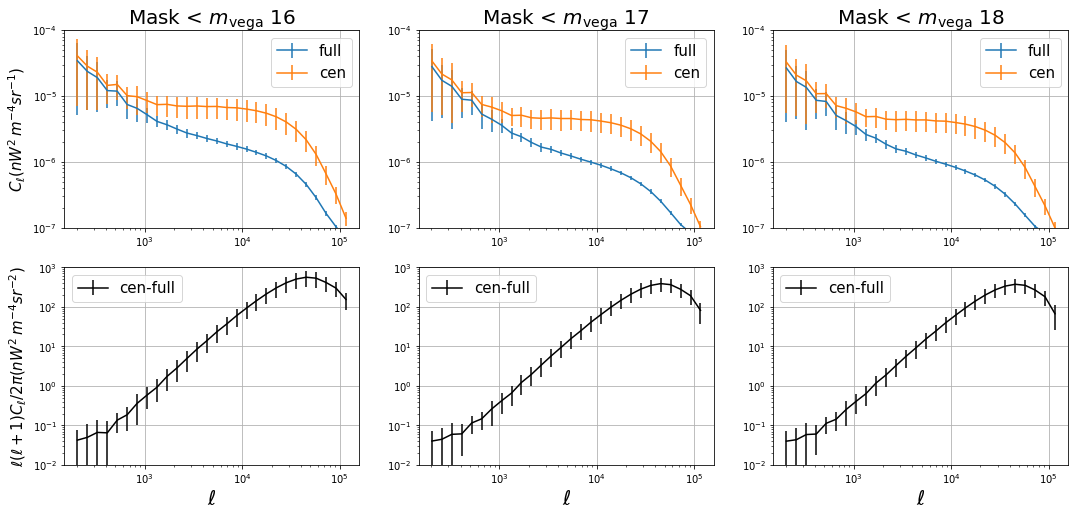

In [82]:
# run_1h_power_spec_test(0-2,m_max_vega=16-18)
fig, ax = plt.subplots(2,3, figsize=(18,8))
inst = 2
for i, m_max_vega in enumerate([16,17,18]):
    Cl_full_arr = []
    Cl_cen_arr = []
    Cl_diff_arr = []
    for ibatch in [0,1,2]:
        fname = 'micecat_data/PS1h_test_ibatch%d_maskth%d.pkl'%(ibatch,m_max_vega)
        with open(fname, "rb") as f:
            data = pickle.load(f)
        for j,icat in enumerate(list(data)):
            if isinstance(icat, str):
                continue
            Cl_full_arr.append(data[icat]['full'][inst]['Cl'])
            Cl_cen_arr.append(data[icat]['cen'][inst]['Cl'])
            Cl_diff_arr.append(data[icat]['cen'][inst]['Cl']-data[icat]['full'][inst]['Cl'])
    Dl_diff_arr = data['l'] * (data['l']+1) * np.array(Cl_diff_arr) / 2 / np.pi
    
    ax[0][i].errorbar(data['l'],np.mean(Cl_full_arr,axis=0),
                      np.std(Cl_full_arr,axis=0),c='C0',label='full')
    ax[0][i].errorbar(data['l'],np.mean(Cl_cen_arr,axis=0),
                      np.std(Cl_cen_arr,axis=0),c='C1',label='cen')
    ax[1][i].errorbar(data['l'],np.mean(Dl_diff_arr,axis=0),
                      np.std(Dl_diff_arr,axis=0),c='k',label='cen-full')
    ax[0][i].grid()
    ax[1][i].grid()
    ax[0][i].legend(fontsize=15)
    ax[1][i].legend(fontsize=15)
    ax[0][i].set_xscale('log')
    ax[0][i].set_yscale('log')
    ax[1][i].set_xscale('log')
    ax[1][i].set_yscale('log')
    ax[1][i].set_xlabel(r'$\ell$',fontsize=20)
    ax[0][i].set_title(r'Mask < $m_{\rm vega}$ %d'%m_max_vega, fontsize=20)
    
    ax[0][i].set_ylim([1e-7,1e-4])
    ax[1][i].set_ylim([1e-2,1e3])
    ax[0][0].set_ylabel(r'$C_\ell( nW^2\,m^{-4} sr^{-1})$',fontsize=15)
    ax[1][0].set_ylabel(r'$\ell(\ell+1)C_\ell/2\pi( nW^2\,m^{-4} sr^{-2})$',fontsize=15)
plt.savefig('/Users/ytcheng/Desktop/PS_sat_test_TM%d.png'%inst,dpi = 150, bbox_inches='tight')

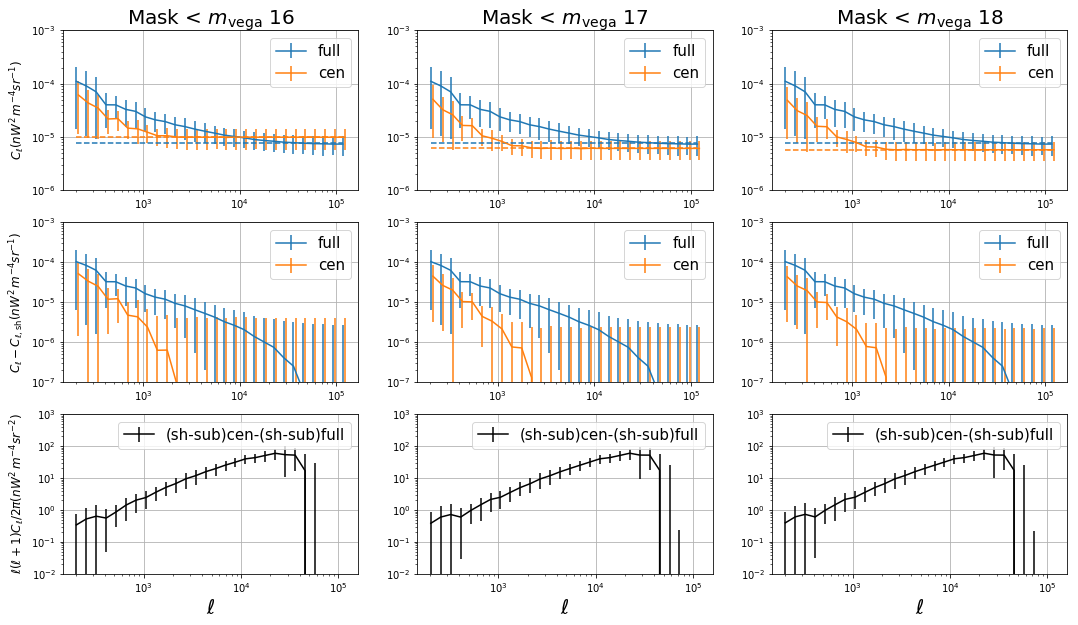

In [38]:
# run_1h_power_spec_test(0-2,m_max_vega=16-18)
fig, ax = plt.subplots(3,3, figsize=(18,10))
inst = 1
for i, m_max_vega in enumerate([16,17,18]):
    Cl_full_arr = []
    Cl_cen_arr = []
    Cl_full_sh_arr = []
    Cl_cen_sh_arr = []
    Cl_diff_arr = []
    for ibatch in [0,1,2]:
        fname = 'micecat_data/PS1h_test_ibatch%d_maskth%d_nopsf.pkl'%(ibatch,m_max_vega)
        with open(fname, "rb") as f:
            data = pickle.load(f)
        for j,icat in enumerate(list(data)):
            if isinstance(icat, str):
                continue
            Cl_full_arr.append(data[icat]['full'][inst]['Cl'])
            Cl_cen_arr.append(data[icat]['cen'][inst]['Cl'])
            Cl_full_sh_arr.append(data[icat]['full'][inst]['Clsh'])
            Cl_cen_sh_arr.append(data[icat]['cen'][inst]['Clsh'])
            Cl_diff_arr.append((data[icat]['full'][inst]['Cl']-data[icat]['full'][inst]['Clsh'])
                               -(data[icat]['cen'][inst]['Cl']-data[icat]['cen'][inst]['Clsh']))
    Cl_full_arr = np.array(Cl_full_arr)
    Cl_cen_arr = np.array(Cl_cen_arr)
    Cl_full_sh_arr = np.array(Cl_full_sh_arr)
    Cl_cen_sh_arr = np.array(Cl_cen_sh_arr)
    Dl_diff_arr = data['l'] * (data['l']+1) * np.array(Cl_diff_arr) / 2 / np.pi
    
    ax[0][i].errorbar(data['l'],np.mean(Cl_full_arr,axis=0),
                      np.std(Cl_full_arr,axis=0),c='C0',label='full')
    ax[0][i].errorbar(data['l']*1.05,np.mean(Cl_cen_arr,axis=0),
                      np.std(Cl_cen_arr,axis=0),c='C1',label='cen')
    ax[0][i].plot(data['l'],np.mean(Cl_full_sh_arr,axis=0),'C0--')
    ax[0][i].plot(data['l'],np.mean(Cl_cen_sh_arr,axis=0),'C1--')
    
    ax[1][i].errorbar(data['l'],np.mean(Cl_full_arr-Cl_full_sh_arr,axis=0),
                      np.std(Cl_full_arr,axis=0),c='C0',label='full')
    ax[1][i].errorbar(data['l']*1.05,np.mean(Cl_cen_arr-Cl_cen_sh_arr,axis=0),
                      np.std(Cl_cen_arr,axis=0),c='C1',label='cen')
    
    ax[2][i].errorbar(data['l'],np.mean(Dl_diff_arr,axis=0),
                      np.std(Dl_diff_arr,axis=0),c='k',label='(sh-sub)cen-(sh-sub)full')
    ax[0][i].grid()
    ax[1][i].grid()
    ax[2][i].grid()
    ax[0][i].legend(fontsize=15)
    ax[1][i].legend(fontsize=15)
    ax[2][i].legend(fontsize=15)
    ax[0][i].set_xscale('log')
    ax[0][i].set_yscale('log')
    ax[1][i].set_xscale('log')
    ax[1][i].set_yscale('log')
    ax[2][i].set_xscale('log')
    ax[2][i].set_yscale('log')
    ax[2][i].set_xlabel(r'$\ell$',fontsize=20)
    ax[0][i].set_title(r'Mask < $m_{\rm vega}$ %d'%m_max_vega, fontsize=20)
    
    ax[0][i].set_ylim([1e-6,1e-3])
    ax[1][i].set_ylim([1e-7,1e-3])
    ax[2][i].set_ylim([1e-2,1e3])
    ax[0][0].set_ylabel(r'$C_\ell( nW^2\,m^{-4} sr^{-1})$',fontsize=12)
    ax[1][0].set_ylabel(r'$C_\ell-C_{\ell,\rm sh}( nW^2\,m^{-4} sr^{-1})$',fontsize=12)
    ax[2][0].set_ylabel(r'$\ell(\ell+1)C_\ell/2\pi( nW^2\,m^{-4} sr^{-2})$',fontsize=12)
plt.savefig('/Users/ytcheng/Desktop/PS_sat_test_TM%d.png'%inst,dpi = 150, bbox_inches='tight')

In [ ]:
m_max_vega=17
icat_arr = [0]
mag_th = m_max_vega - 2.5*np.log10(1594./3631.)
make_srcmap_class1 = make_srcmap(1)
make_srcmap_class2 = make_srcmap(2)

data = {'icat_arr':icat_arr}
for icat in icat_arr:
    print('icat %d'%icat)
    data[icat] = {}
    df = get_micecat_df(icat)
    df['Fnu_I'] = 3631 * 10**(-df['I'] / 2.5)
    df['Fnu_H'] = 3631 * 10**(-df['H'] / 2.5)
    nuFnu_I = np.array(make_srcmap_class1._ABmag2Iciber(df['I'].copy()))
    nuFnu_H = np.array(make_srcmap_class2._ABmag2Iciber(df['H'].copy()))
    idx_b = np.where(df['I'] < mag_th)[0]
    f_res1,f_res2 = np.ones(len(df)),np.ones(len(df))

    start_time = time.time()
    for i,idx in enumerate(idx_b):
        if i%(len(idx_b)//10)==0:
            print('Calculate residual flux of masked sources %d / %d (%.1f %%),t = %.2f min'\
                  %(i, len(idx_b), i/len(idx_b)*100, (time.time()-start_time)/60))
        dfi = df.iloc[idx]
        mask,_ = MZ14_mask(1,np.array([dfi['x']]),np.array([dfi['y']]),
                             np.array([dfi['I']]),m_max_vega=m_max_vega,verbose=True)
        make_srcmap_class1.ms = np.array([dfi['I']])
        make_srcmap_class1.xls = np.array([dfi['x']])
        make_srcmap_class1.yls = np.array([dfi['y']])
        make_srcmap_class2.ms = np.array([dfi['I']])
        make_srcmap_class2.xls = np.array([dfi['x']])
        make_srcmap_class2.yls = np.array([dfi['y']])
        make_srcmap_class1.ms_inband = np.array([dfi['I']])
        make_srcmap_class2.ms_inband = np.array([dfi['H']])

        srcmapb1 = make_srcmap_class1.run_srcmap(ptsrc=True, verbose=False)
        srcmapb2 = make_srcmap_class2.run_srcmap(ptsrc=True, verbose=False)
        f_res1[idx] = np.sum(srcmapb1[mask==1]) / nuFnu_I[idx]
        f_res2[idx] = np.sum(srcmapb2[mask==1]) / nuFnu_H[idx]

    df['Fnu_I_res'] = df['Fnu_I'].copy() * f_res1
    df['Fnu_H_res'] = df['Fnu_H'].copy() * f_res2        
    dfc = df.loc[df['flag_central']==0]
    dfsum = df.groupby('unique_halo_id')[['Fnu_I_res','Fnu_H_res']].sum()
    dfsum.rename(columns={'Fnu_I_res':'Fnu_I_res_sum','Fnu_H_res':'Fnu_H_res_sum'}, inplace=True)
    dfc = dfc.join(dfsum, on='unique_halo_id', how='inner')
    dfc['I'] = -2.5 * np.log10(dfc['Fnu_I_res_sum']/3631)
    dfc['H'] = -2.5 * np.log10(dfc['Fnu_H_res_sum']/3631) 
    df['I'] = -2.5 * np.log10(df['Fnu_I_res']/3631)
    df['H'] = -2.5 * np.log10(df['Fnu_H_res']/3631) 

    for i,(name,dfi) in enumerate(zip(['full','cen'],[df,dfc])):
        data[icat][name] = {}
        xs, ys, ms = np.array(dfi['x']), np.array(dfi['y']), np.array(dfi['I'])

        for inst in [1]:
            data[icat][name][inst] = {}
            ms_inband = np.array(dfi['I']) if inst==1 else np.array(dfi['H'])

            print('making srcmap for %s TM %d'%(name,inst))
            make_srcmap_class = make_srcmap_class1 if inst==1 else make_srcmap_class2

            make_srcmap_class.ms = ms
            make_srcmap_class.ms_inband = ms_inband
            make_srcmap_class.xls = xs
            make_srcmap_class.yls = ys
            srcmapf = make_srcmap_class.run_srcmap_nopsf()
            srcmap = srcmapf
            l,Cl,Clerr = get_power_spec(srcmap)
            data[icat][name][inst]['Cl'] = Cl
            data[icat][name][inst]['Clerr'] = Clerr
            Omega_pix = ((7*u.arcsec)**2).to(u.sr).value
            data[icat][name][inst]['Clsh'] = np.var(srcmap)*Omega_pix*np.ones_like(Cl)
            data[icat][name][inst]['mean'] = np.mean(srcmap)
            print(name, inst, data[icat][name][inst]['mean'])
    data['l'] = l

icat 0
MICECAT field 0, 0 < ra < 2, 0 < dec < 2
Calculate residual flux of masked sources 0 / 921 (0.0 %),t = 0.00 min
Calculate residual flux of masked sources 92 / 921 (10.0 %),t = 5.37 min
Calculate residual flux of masked sources 184 / 921 (20.0 %),t = 11.13 min
